# Wisconsin Breast Cancer

## Importing libraries

In [1]:
import sys
sys.path.append('../') 
from imports import *

## Loading dataset

In [2]:
# Fetch the Adult dataset with as_frame=True to get a DataFrame
adult_dataset = fetch_openml(name='adult', version=2, as_frame=True)

# The dataset is now a DataFrame with feature names as columns
X = adult_dataset['data']  # Features as a DataFrame
y = adult_dataset['target'].apply(lambda x: 0 if x == '<=50K' else 1)  # Labels as a Series

# Combine the features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

# Rename the target series to have a meaningful column name
df.rename(columns={ df.columns[-1]: "target" }, inplace = True)
df.head()

/home/vs/.virtualenvs/torch/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


## EDA: Exploratory Data analysis

### Missing values

In [3]:
# missing values in 3 categorical columns: workclass, occupation, native-country
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
target               0
dtype: int64

Ways to handle missing values:
1. Imputation with placeholder category: 'Missing' or 'Not available NA'
2. Removal of rows with missing values (throwing the information) - doing this as instructed
3. Removal of features with missing values (throwing the information)

In [4]:
df_cleaned = df.dropna(subset=['workclass', 'occupation', 'native-country'])
df_cleaned.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  float64 
 1   workclass       45222 non-null  category
 2   fnlwgt          45222 non-null  float64 
 3   education       45222 non-null  category
 4   education-num   45222 non-null  float64 
 5   marital-status  45222 non-null  category
 6   occupation      45222 non-null  category
 7   relationship    45222 non-null  category
 8   race            45222 non-null  category
 9   sex             45222 non-null  category
 10  capital-gain    45222 non-null  float64 
 11  capital-loss    45222 non-null  float64 
 12  hours-per-week  45222 non-null  float64 
 13  native-country  45222 non-null  category
 14  target          45222 non-null  category
dtypes: category(9), float64(6)
memory usage: 2.8 MB


In [6]:
df_cleaned['target'].value_counts()

target
0    34014
1    11208
Name: count, dtype: int64

## encoding categorical columns

In [7]:
categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
if 'target' in categorical_columns:
    categorical_columns.remove('target')
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [8]:
df['workclass'].value_counts()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

### doing label encoding makes sense for columns: 'workclass', 'education', since there are so many categories the dataset would become wider and sparse, so doing label encoding instead of one-hot encoding

In [9]:
label_encoder = LabelEncoder()
# Dictionary to store mappings
label_mappings = {}

# Apply label encoding and store mappings
for col in categorical_columns:
    df_cleaned.loc[:, col] = label_encoder.fit_transform(df_cleaned[col])
    label_mappings[col] = {i: label for i, label in enumerate(label_encoder.classes_)}

df_cleaned.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,2,226802.0,1,7.0,4,6,3,2,1,0.0,0.0,40.0,38,0
1,38.0,2,89814.0,11,9.0,2,4,0,4,1,0.0,0.0,50.0,38,0
2,28.0,1,336951.0,7,12.0,2,10,0,4,1,0.0,0.0,40.0,38,1
3,44.0,2,160323.0,15,10.0,2,6,0,2,1,7688.0,0.0,40.0,38,1
5,34.0,2,198693.0,0,6.0,4,7,1,4,1,0.0,0.0,30.0,38,0


In [10]:
label_mappings

{'workclass': {0: 'Federal-gov',
  1: 'Local-gov',
  2: 'Private',
  3: 'Self-emp-inc',
  4: 'Self-emp-not-inc',
  5: 'State-gov',
  6: 'Without-pay'},
 'education': {0: '10th',
  1: '11th',
  2: '12th',
  3: '1st-4th',
  4: '5th-6th',
  5: '7th-8th',
  6: '9th',
  7: 'Assoc-acdm',
  8: 'Assoc-voc',
  9: 'Bachelors',
  10: 'Doctorate',
  11: 'HS-grad',
  12: 'Masters',
  13: 'Preschool',
  14: 'Prof-school',
  15: 'Some-college'},
 'marital-status': {0: 'Divorced',
  1: 'Married-AF-spouse',
  2: 'Married-civ-spouse',
  3: 'Married-spouse-absent',
  4: 'Never-married',
  5: 'Separated',
  6: 'Widowed'},
 'occupation': {0: 'Adm-clerical',
  1: 'Armed-Forces',
  2: 'Craft-repair',
  3: 'Exec-managerial',
  4: 'Farming-fishing',
  5: 'Handlers-cleaners',
  6: 'Machine-op-inspct',
  7: 'Other-service',
  8: 'Priv-house-serv',
  9: 'Prof-specialty',
  10: 'Protective-serv',
  11: 'Sales',
  12: 'Tech-support',
  13: 'Transport-moving'},
 'relationship': {0: 'Husband',
  1: 'Not-in-family',
 

### Class imbalance

In [11]:
# Too much class imbalance, how to handle this?
df_cleaned.target.value_counts()

target
0    34014
1    11208
Name: count, dtype: int64

In [12]:
# Count the occurrences of each class (1 and 0)
class_counts = df_cleaned['target'].value_counts()
class_percentages = class_counts / len(df) * 100

# print(f"Class Percentages: {class_percentages:.2f}")
for class_label, percentage in class_percentages.items():
    print(f"Class {class_label}: {percentage:.2f}%")

Class 0: 69.64%
Class 1: 22.95%


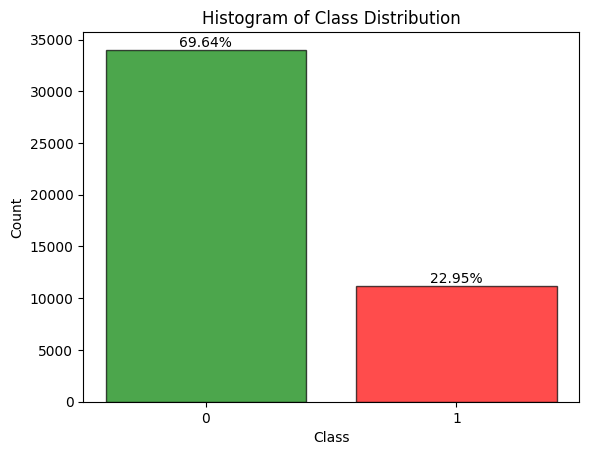

In [13]:
# Plotting histogram with different colors for each class
plt.bar(0, class_counts[0], color='green', edgecolor='black', alpha=0.7)
plt.bar(1, class_counts[1], color='red', edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.title('Histogram of Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Annotating the histogram with class percentages
plt.text(0, class_counts[0], f'{class_percentages[0]:.2f}%', ha='center', va='bottom')
plt.text(1, class_counts[1], f'{class_percentages[1]:.2f}%', ha='center', va='bottom')

plt.show()

### Correlation matrix

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  float64 
 1   workclass       45222 non-null  int64   
 2   fnlwgt          45222 non-null  float64 
 3   education       45222 non-null  int64   
 4   education-num   45222 non-null  float64 
 5   marital-status  45222 non-null  int64   
 6   occupation      45222 non-null  int64   
 7   relationship    45222 non-null  int64   
 8   race            45222 non-null  int64   
 9   sex             45222 non-null  int64   
 10  capital-gain    45222 non-null  float64 
 11  capital-loss    45222 non-null  float64 
 12  hours-per-week  45222 non-null  float64 
 13  native-country  45222 non-null  int64   
 14  target          45222 non-null  category
dtypes: category(1), float64(6), int64(8)
memory usage: 5.2 MB


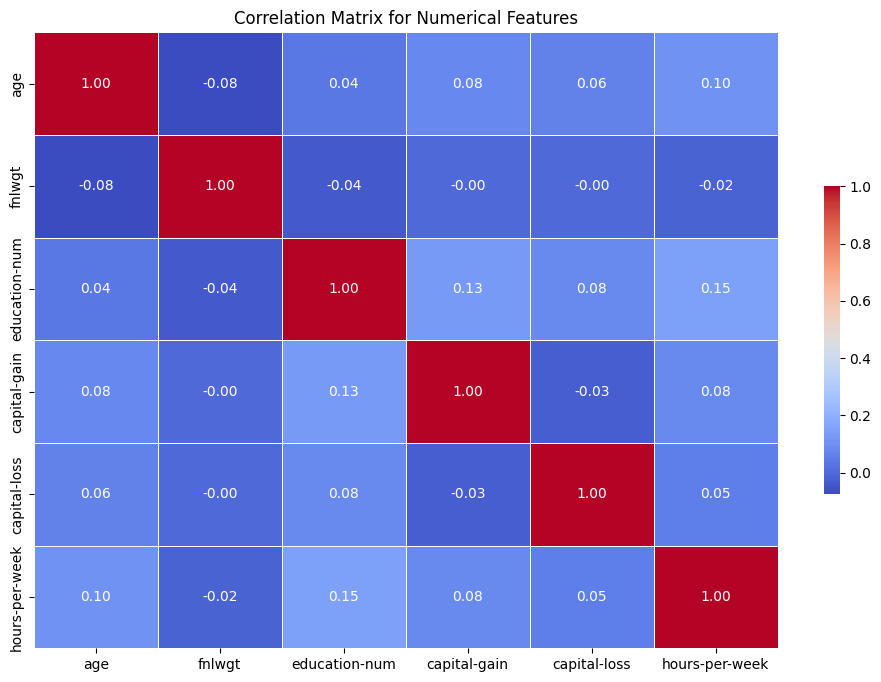

In [15]:
# Select only the numerical columns from the DataFrame
numerical_df = df_cleaned.select_dtypes(include=['float64'])

# Calculate the correlation matrix for the numerical features
correlation_matrix_numerical = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numerical, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for Numerical Features')
plt.show()

## now divide the data into train, val, test sets while maintaining the class imbalance

In [16]:
target_column = 'target'

# First, split into training and a temporary test set
df_train, df_temp = train_test_split(df_cleaned, test_size=0.3, random_state=1, stratify=df_cleaned[target_column])

# Then split the temporary test set into validation and test sets
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1, stratify=df_temp[target_column])


In [17]:
df_train.target.value_counts()

target
0    23809
1     7846
Name: count, dtype: int64

In [18]:
def calculate_class_percentages(df, target_column):
    class_counts = df[target_column].value_counts(normalize=True) * 100
    return class_counts

# Calculate class percentages in each set
train_class_percentages = calculate_class_percentages(df_train, target_column)
val_class_percentages = calculate_class_percentages(df_val, target_column)
test_class_percentages = calculate_class_percentages(df_test, target_column)

# Display the percentages
print("Training Set Class Percentages:\n", train_class_percentages)
print("\nValidation Set Class Percentages:\n", val_class_percentages)
print("\nTest Set Class Percentages:\n", test_class_percentages)


Training Set Class Percentages:
 target
0    75.214026
1    24.785974
Name: proportion, dtype: float64

Validation Set Class Percentages:
 target
0    75.217455
1    24.782545
Name: proportion, dtype: float64

Test Set Class Percentages:
 target
0    75.221108
1    24.778892
Name: proportion, dtype: float64


## now saving datasets for future use

In [19]:
df_train.to_csv('./uci-adult-processed-data/train.csv', index=False)
df_val.to_csv('./uci-adult-processed-data/val.csv', index=False)
df_test.to_csv('./uci-adult-processed-data/test.csv', index=False)
